# Songs Exploratory Data Analysis

In [68]:
# Importing necessary modules
from pyspark.sql import SparkSession
import pyspark.sql.functions as fun
import matplotlib.pyplot as plt
from pyspark.ml.feature import VectorAssembler, StringIndexer, StandardScaler
from pyspark.ml import Pipeline
from sklearn.metrics import confusion_matrix
from pyspark.ml.classification import LogisticRegression
import os, sys
import pandas as pd
import numpy as np
import seaborn as sns 


In [2]:
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPAK_DRIVER_PYTHON'] = sys.executable

In [69]:
# Creating a spark session
spark = SparkSession.builder.master("local[1]").appName("Spotify_Recommendations").getOrCreate()

In [3]:
spark

In [56]:
# Reading the dataset using spark. Setting inferSchema=True so that spark can
# intelligently read the CSV file and set the datatypes of all columns
df = spark.read.csv("songs_data.csv", header=True, inferSchema=True)

In [57]:
# Showing first 5 row of the read data
df.show(5)

+---+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+
|_c0|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|liked/disliked|
+---+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+
|  1|       0.652| 0.557|1.0|  -5.714| 0.0|     0.0318|        0.74|             0.0|   0.124|  0.483|150.073|             1|
|  2|       0.624| 0.632|1.0| -13.824| 1.0|     0.0534|     0.00517|           0.658|    0.15|  0.334|132.001|             1|
|  3|       0.552| 0.531|7.0|  -7.732| 1.0|     0.0421|       0.241|         1.21E-5|   0.122|  0.438|144.946|             1|
|  4|       0.628| 0.698|6.0|  -5.608| 0.0|      0.105|      0.0472|         0.00143|  0.0907|  0.732| 89.976|             1|
|  5|       0.496| 0.863|9.0|  -4.153| 1.0|     0.0381|      0.0046|             0.0|   0.639|  0.243|110.018|        

23/07/16 17:23:57 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , danceability, energy, key, loudness, mode, speechiness, acousticness, instrumentalness, liveness, valence, tempo, liked/disliked
 Schema: _c0, danceability, energy, key, loudness, mode, speechiness, acousticness, instrumentalness, liveness, valence, tempo, liked/disliked
Expected: _c0 but found: 
CSV file: file:///Users/raveeshyadav/GitHub/Spotify-recommendations/songs_data.csv


In [58]:
# Removing column _c0 as it is vestigial
df = df.drop(fun.col('_c0'))
df.show(5)

+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+
|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|liked/disliked|
+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+
|       0.652| 0.557|1.0|  -5.714| 0.0|     0.0318|        0.74|             0.0|   0.124|  0.483|150.073|             1|
|       0.624| 0.632|1.0| -13.824| 1.0|     0.0534|     0.00517|           0.658|    0.15|  0.334|132.001|             1|
|       0.552| 0.531|7.0|  -7.732| 1.0|     0.0421|       0.241|         1.21E-5|   0.122|  0.438|144.946|             1|
|       0.628| 0.698|6.0|  -5.608| 0.0|      0.105|      0.0472|         0.00143|  0.0907|  0.732| 89.976|             1|
|       0.496| 0.863|9.0|  -4.153| 1.0|     0.0381|      0.0046|             0.0|   0.639|  0.243|110.018|             1|
+------------+------+---

In [59]:
# Printing the schema for our data
df.printSchema()

root
 |-- danceability: double (nullable = true)
 |-- energy: double (nullable = true)
 |-- key: double (nullable = true)
 |-- loudness: double (nullable = true)
 |-- mode: double (nullable = true)
 |-- speechiness: double (nullable = true)
 |-- acousticness: double (nullable = true)
 |-- instrumentalness: double (nullable = true)
 |-- liveness: double (nullable = true)
 |-- valence: double (nullable = true)
 |-- tempo: double (nullable = true)
 |-- liked/disliked: integer (nullable = true)



In [60]:
# Shape of the dataset
print('Shape of the dataset: ', (df.count(), len(df.columns)))

Shape of the dataset:  (137, 12)


In [61]:
# Checking whether the datset contains of any null values or not
df.agg(*[fun.count(fun.when(fun.isnull(column),column)).alias(column)for column in df.columns]).show()

+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-----+--------------+
|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|tempo|liked/disliked|
+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-----+--------------+
|           2|     2|  2|       2|   2|          2|           2|               2|       2|      2|    2|             0|
+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-----+--------------+



In [62]:
# We can see that there are null values in our datset. Hence, we will remove them
# and re-verify for the null values 
df = df.na.drop()   # drop null values
df.agg(*[fun.count(fun.when(fun.isnull(column),column)).alias(column)for column in df.columns]).show()

+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-----+--------------+
|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|tempo|liked/disliked|
+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-----+--------------+
|           0|     0|  0|       0|   0|          0|           0|               0|       0|      0|    0|             0|
+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-----+--------------+



In [63]:
# Sumarizing the data in order to get a glimpse of the values and content of data 
df.describe().show()

+-------+-------------------+------------------+------------------+------------------+------------------+-------------------+-------------------+--------------------+-------------------+-------------------+------------------+------------------+
|summary|       danceability|            energy|               key|          loudness|              mode|        speechiness|       acousticness|    instrumentalness|           liveness|            valence|             tempo|    liked/disliked|
+-------+-------------------+------------------+------------------+------------------+------------------+-------------------+-------------------+--------------------+-------------------+-------------------+------------------+------------------+
|  count|                135|               135|               135|               135|               135|                135|                135|                 135|                135|                135|               135|               135|
|   mean| 0.61310370

In [64]:
# Converting out datset into a pandas dataframe so that we can plot to get visual insights
data = df.toPandas()

In [65]:
# Printing first 5 elements of our pandas dataframe
data.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,liked/disliked
0,0.652,0.557,1.0,-5.714,0.0,0.0318,0.74000,0.000000,0.1240,0.483,150.073,1
1,0.624,0.632,1.0,-13.824,1.0,0.0534,0.00517,0.658000,0.1500,0.334,132.001,1
2,0.552,0.531,7.0,-7.732,1.0,0.0421,0.24100,0.000012,0.1220,0.438,144.946,1
3,0.628,0.698,6.0,-5.608,0.0,0.1050,0.04720,0.001430,0.0907,0.732,89.976,1
4,0.496,0.863,9.0,-4.153,1.0,0.0381,0.00460,0.000000,0.6390,0.243,110.018,1


<AxesSubplot:>

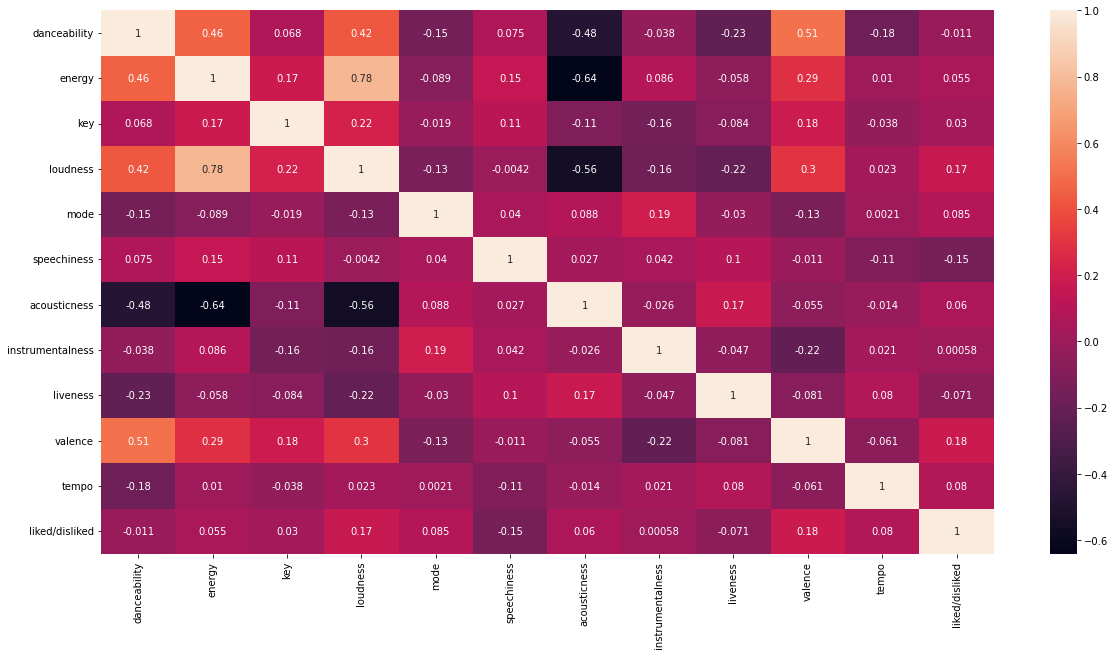

In [67]:
# Plotting a seaborn heatmap of our data. The hatmap will show relation between all the features

plt.figure(figsize=(20,10))
sns.heatmap(data.corr(), annot = True)

In [53]:
data['acousticness'].mean

0      0.74000
1      0.00517
2      0.24100
3      0.04720
4      0.00460
        ...   
130    0.06820
131    0.10400
132    0.07710
133    0.01370
134    0.24100
Name: acousticness, Length: 135, dtype: float64

<AxesSubplot:xlabel='liked/disliked', ylabel='count'>

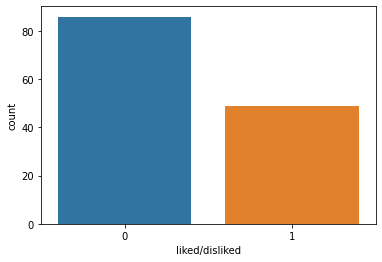

In [41]:
# Printing a count plot top see how much data is present for each liked as well as disliked song
sns.countplot(x='liked/disliked',data=data)

/var/folders/qh/sckhy9cx1y13y4gg32cmhqv80000gn/T/ipykernel_2163/1732384288.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['danceability'])


<AxesSubplot:xlabel='danceability', ylabel='Density'>

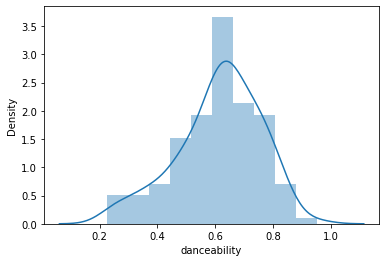

In [42]:
# Plotting user data's danceability trends
sns.distplot(data['danceability'])

/var/folders/qh/sckhy9cx1y13y4gg32cmhqv80000gn/T/ipykernel_2163/1084219847.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['energy'])


<AxesSubplot:xlabel='energy', ylabel='Density'>

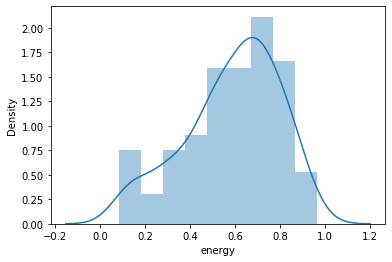

In [43]:
# Plotting user data's energy trends
sns.distplot(data['energy'])

/var/folders/qh/sckhy9cx1y13y4gg32cmhqv80000gn/T/ipykernel_2163/1246644979.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['key'])


<AxesSubplot:xlabel='key', ylabel='Density'>

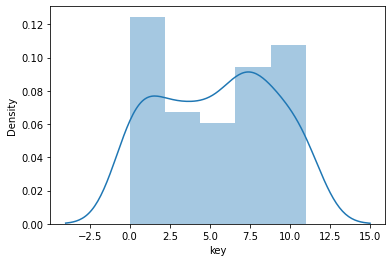

In [44]:
# Plotting user data's key trends
sns.distplot(data['key'])

/var/folders/qh/sckhy9cx1y13y4gg32cmhqv80000gn/T/ipykernel_2163/1778381608.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['loudness'])


<AxesSubplot:xlabel='loudness', ylabel='Density'>

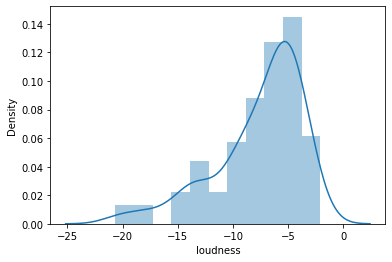

In [45]:
# Plotting user data's key trends
sns.distplot(data['loudness'])

/var/folders/qh/sckhy9cx1y13y4gg32cmhqv80000gn/T/ipykernel_2163/1059728595.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['mode'])


<AxesSubplot:xlabel='mode', ylabel='Density'>

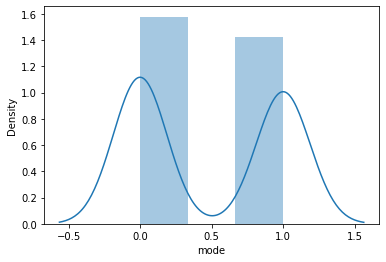

In [46]:
# Plotting user data's mode trends
sns.distplot(data['mode'])

/var/folders/qh/sckhy9cx1y13y4gg32cmhqv80000gn/T/ipykernel_2163/773829482.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['speechiness'])


<AxesSubplot:xlabel='speechiness', ylabel='Density'>

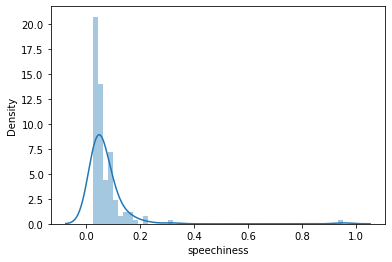

In [47]:
# Plotting user data's speachiness trends
sns.distplot(data['speechiness'])

/var/folders/qh/sckhy9cx1y13y4gg32cmhqv80000gn/T/ipykernel_2163/1984739871.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['acousticness'])


<AxesSubplot:xlabel='acousticness', ylabel='Density'>

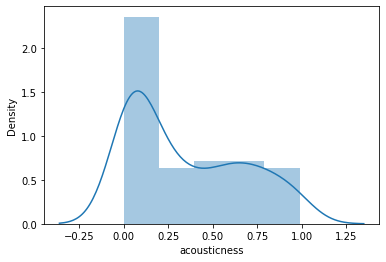

In [48]:
# Plotting user data's acousticness trends
sns.distplot(data['acousticness'])

/var/folders/qh/sckhy9cx1y13y4gg32cmhqv80000gn/T/ipykernel_2163/297831868.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['instrumentalness'])


<AxesSubplot:xlabel='instrumentalness', ylabel='Density'>

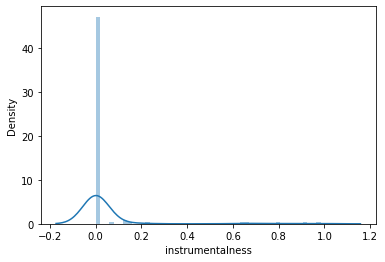

In [49]:
# Plotting user data's instrumentalness trends
sns.distplot(data['instrumentalness'])

/var/folders/qh/sckhy9cx1y13y4gg32cmhqv80000gn/T/ipykernel_2163/437609218.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['valence'])


<AxesSubplot:xlabel='valence', ylabel='Density'>

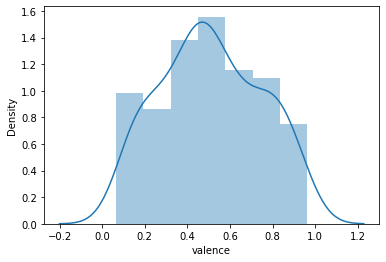

In [50]:
# Plotting user data's valence trends
sns.distplot(data['valence'])

/var/folders/qh/sckhy9cx1y13y4gg32cmhqv80000gn/T/ipykernel_2163/3810897301.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['tempo'])


<AxesSubplot:xlabel='tempo', ylabel='Density'>

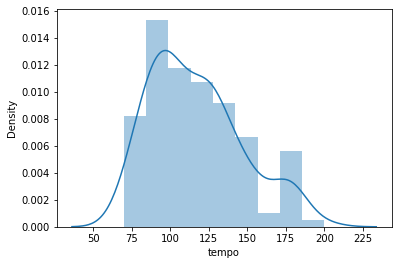

In [51]:
# Plotting user data's tempo trends
sns.distplot(data['tempo'])